Data Beras Medium (Target: Wlingi_Beras Medium) berhasil digabungkan. Ukuran data: 320

  UJI STASIONERITAS (ADF TEST) - Wlingi_Beras Medium
Statistic Uji ADF: -3.2482
p-value: 0.01735811129584295
Critical Values:
	1%: -3.4522
	5%: -2.8712
	10%: -2.5719

Kesimpulan: Data adalah STASIONER. (Tolak hipotesis nol)

--- Visualisasi Data Asli (Sebelum Differencing) ---
Plot ACF/PACF Data Asli telah disimpan sebagai 'analisis_beras_medium_ACF_PACF_RAW.png'

--- Visualisasi Data Stasioner (Setelah Differencing) ---

Visualisasi data stasioner telah disimpan sebagai 'analisis_beras_medium_stationary.png'


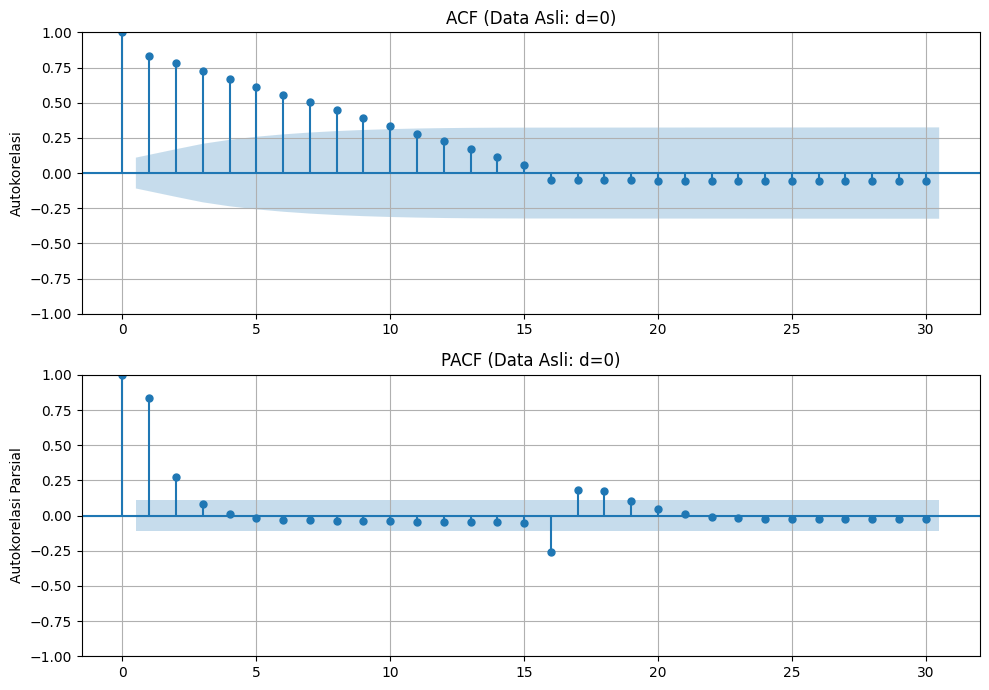

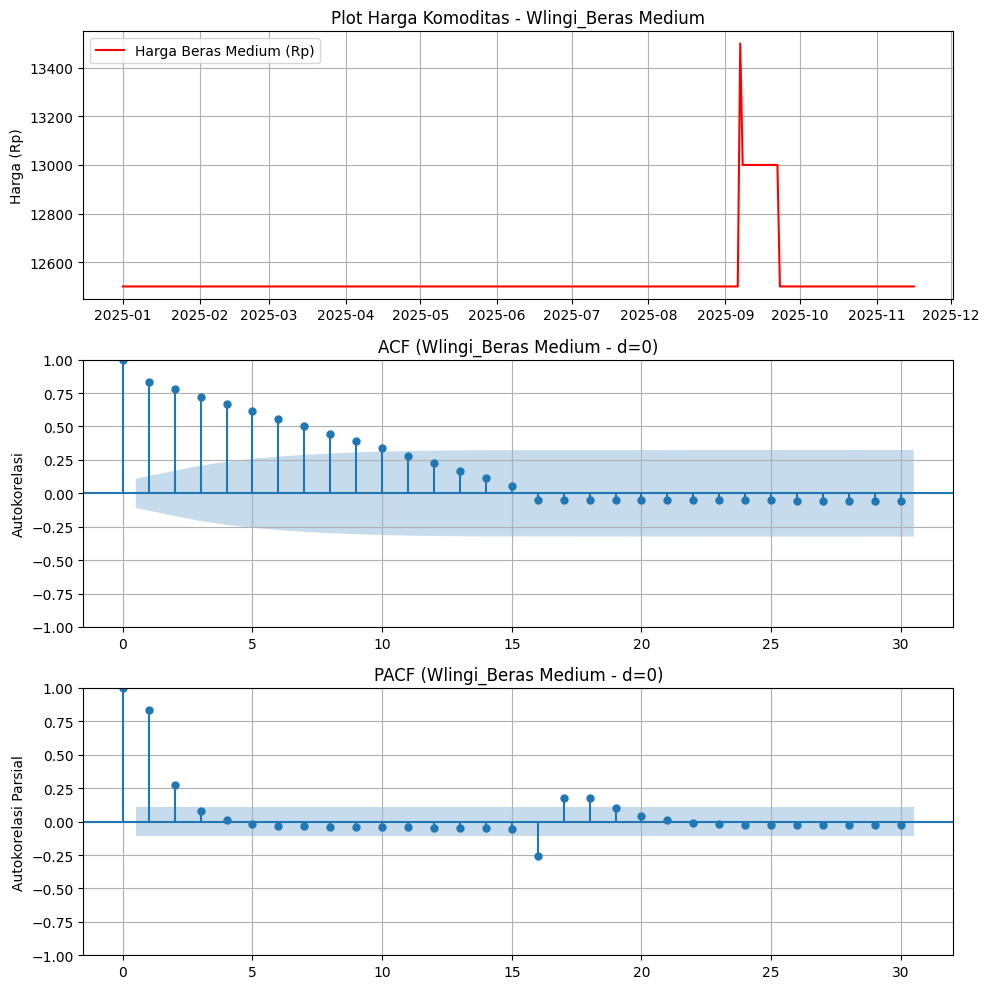

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import re 

warnings.filterwarnings("ignore")

# ==============================================================================
# 1. LOAD DAN PEMBERSIHAN DATA
# ==============================================================================
def load_and_clean_data(file_path, market_name):
    """Memuat, membersihkan, dan mengatur indeks tanggal."""
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    
    # Konversi kolom 'Tanggal' ke datetime
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y', errors='coerce')
    df.set_index('Tanggal', inplace=True)
    
    # Cleaning dan Konversi Harga
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[Rp\s,.]', '', regex=True)
            df[col] = df[col].replace({'': np.nan, 'nan': np.nan}) 
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.interpolate(method='linear')
    df = df.add_prefix(f'{market_name}_')
    return df

# Memuat data dari kedua pasar
df_lodoyo = load_and_clean_data('/PA/dataset/pasar-lodoyo.csv', 'Lodoyo')
df_wlingi = load_and_clean_data('/PA/dataset/pasar-wlingi.csv', 'Wlingi')

# Menggabungkan data berdasarkan indeks Tanggal
df_merged = pd.merge(df_wlingi, df_lodoyo, left_index=True, right_index=True, how='inner')

# PILIH KOMODITAS: Beras Medium
target_col = 'Wlingi_Beras Medium'
exog_col = 'Lodoyo_Beras Medium'
data_bem = df_merged[target_col].astype(float).dropna()

print(f"Data Beras Medium (Target: {target_col}) berhasil digabungkan. Ukuran data: {len(data_bem)}")

# ==============================================================================
# 2. UJI STASIONERITAS (ADF TEST) pada Target
# ==============================================================================
print("\n" + "="*45)
print(f"  UJI STASIONERITAS (ADF TEST) - {target_col}")
print("="*45)

def adf_test(series):
    """Fungsi untuk menjalankan dan mencetak hasil ADF Test."""
    if series.max() == series.min():
        print("Nilai input konstan setelah cleaning/interpolasi. Uji ADF tidak mungkin.")
        return 0
        
    result = adfuller(series, autolag='AIC')
    print(f'Statistic Uji ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("\nKesimpulan: Data adalah STASIONER. (Tolak hipotesis nol)")
        return 0
    else:
        print("\nKesimpulan: Data TIDAK STASIONER. (Gagal menolak hipotesis nol)")
        # Kita akan coba differencing tingkat 1
        d_val = adf_test(series.diff().dropna())
        return d_val + 1

d_bem = adf_test(data_bem)

# ==============================================================================
# 3. VISUALISASI DERET WAKTU DAN AUTOKORELASI
# ==============================================================================

# Data setelah differencing (data yang STASIONER)
data_plot_stationary = data_bem.diff(d_bem).dropna() if d_bem > 0 else data_bem
plot_title_stationary = f'({target_col} - d={d_bem})'

# --- A. PLOT DATA ASLI (Sebelum Differencing) ---
print("\n--- Visualisasi Data Asli (Sebelum Differencing) ---")
fig_raw, axes_raw = plt.subplots(2, 1, figsize=(10, 7))
plt.subplots_adjust(hspace=0.4)

# Plot Autokorelasi (ACF) Data Asli
plot_acf(data_bem, ax=axes_raw[0], lags=30, title=f'ACF (Data Asli: d=0)')
axes_raw[0].grid(True)
axes_raw[0].set_ylabel('Autokorelasi')

# Plot Autokorelasi Parsial (PACF) Data Asli
plot_pacf(data_bem, ax=axes_raw[1], lags=30, title=f'PACF (Data Asli: d=0)')
axes_raw[1].grid(True)
axes_raw[1].set_ylabel('Autokorelasi Parsial')

plt.tight_layout()
plt.savefig('analisis_beras_medium_ACF_PACF_RAW.png')
print("Plot ACF/PACF Data Asli telah disimpan sebagai 'analisis_beras_medium_ACF_PACF_RAW.png'")


# --- B. PLOT DATA STASIONER (Setelah Differencing) ---
print("\n--- Visualisasi Data Stasioner (Setelah Differencing) ---")
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

# Plot Deret Waktu Asli
axes[0].plot(data_bem, label='Harga Beras Medium (Rp)', color='red')
axes[0].set_title(f'Plot Harga Komoditas - {target_col}')
axes[0].set_ylabel('Harga (Rp)')
axes[0].grid(True)
axes[0].legend()

# Plot Autokorelasi (ACF) Data Stasioner
plot_acf(data_plot_stationary, ax=axes[1], lags=30, title=f'ACF {plot_title_stationary}')
axes[1].grid(True)
axes[1].set_ylabel('Autokorelasi')

# Plot Autokorelasi Parsial (PACF) Data Stasioner
plot_pacf(data_plot_stationary, ax=axes[2], lags=30, title=f'PACF {plot_title_stationary}')
axes[2].grid(True)
axes[2].set_ylabel('Autokorelasi Parsial')

plt.tight_layout()
plt.savefig('analisis_beras_medium_stationary.png')
print("\nVisualisasi data stasioner telah disimpan sebagai 'analisis_beras_medium_stationary.png'")

In [21]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. SETUP ---
import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

def ensure_dir(directory):
    if not os.path.exists(directory): os.makedirs(directory)

# --- 2. FUNGSI CLEANING SUPER KETAT ---
def clean_super_strict(file_path, market_name):
    print(f"--- Memproses {market_name} ---")
    df = pd.read_csv(file_path, dtype=str) # Baca semua sebagai string dulu
    
    # Cari kolom tanggal
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower()), None)
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
    
    for col in df.columns:
        if re.search(r'harga|beras', col, re.IGNORECASE):
            # Ambil contoh data mentah
            print(f"Contoh mentah {col}: {df[col].iloc[0]} s/d {df[col].iloc[-1]}")
            
            # HAPUS "Rp", " ", dan "," (koma dianggap desimal dibuang)
            # Logika: Ambil angka sebelum koma saja
            df[col] = df[col].astype(str).apply(lambda x: x.split(',')[0]) 
            # Hapus titik (pemisah ribuan)
            df[col] = df[col].str.replace('.', '', regex=False)
            # Hapus karakter non-angka
            df[col] = df[col].str.replace(r'\D', '', regex=True)
            
            # Convert ke Float
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # CEK ANOMALI (Kalau ada harga > 50.000 untuk beras, pasti salah input jutaan)
            median_val = df[col].median()
            if median_val > 50000:
                print(f"⚠ DETEKSI HARGA JUTAAN di {col} (Median: {median_val}). Membagi 100...")
                df[col] = df[col] / 100
                
            # Interpolasi
            df[col] = df[col].interpolate().fillna(method='ffill').fillna(method='bfill')
            
            print(f"-> Hasil bersih {col}: Min={df[col].min()}, Max={df[col].max()}")

    return df.add_prefix(f'{market_name}_')

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# --- 3. EKSEKUSI ---
file_wlingi = '/PA/dataset/pasar-wlingi.csv'
file_lodoyo = '/PA/dataset/pasar-lodoyo.csv'
OUT_DIR = 'outputs_debug_fix'
ensure_dir(OUT_DIR)

# A. Load & Clean
df_wlingi = clean_super_strict(file_wlingi, 'Wlingi')
df_lodoyo = clean_super_strict(file_lodoyo, 'Lodoyo')
df_merged = df_wlingi.join(df_lodoyo, how='inner')

target_col = 'Wlingi_Beras Medium'
exog_col = 'Lodoyo_Beras Medium'
data = df_merged[[target_col, exog_col]].dropna()

print(f"\nDATA SIAP. Total Baris: {len(data)}")
print(data.head())

# B. Split & Scale
train_size = int(len(data) * 0.8) 
train_values = data.iloc[:train_size].values.astype('float32')
test_values = data.iloc[train_size:].values.astype('float32')

print("\n--- CEK SCALING ---")
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

print(f"Train Scaled Max: {train_scaled.max()} (Harus 1.0)")
print(f"Test Scaled Max : {test_scaled.max()} (Harus sekitar 1.0, JANGAN RIBUAN)")

if test_scaled.max() > 5:
    print("⛔ STOP! Test Data masih bocor (nilai terlalu besar).")
else:
    print("✅ DATA AMAN. Lanjut Training...")

--- Memproses Wlingi ---
Contoh mentah Beras Premium: 14600 s/d 14900
-> Hasil bersih Beras Premium: Min=14600, Max=15000
Contoh mentah Beras Medium: 12500 s/d 12500
-> Hasil bersih Beras Medium: Min=12500, Max=13500
--- Memproses Lodoyo ---
Contoh mentah Beras Premium: 14400 s/d 14900
-> Hasil bersih Beras Premium: Min=14400, Max=15000
Contoh mentah Beras Medium: 12500 s/d 12500
-> Hasil bersih Beras Medium: Min=12500, Max=13500

DATA SIAP. Total Baris: 320
            Wlingi_Beras Medium  Lodoyo_Beras Medium
Tanggal                                             
2025-01-01                12500                12500
2025-01-02                12500                12500
2025-01-03                12500                12500
2025-01-04                12500                12500
2025-01-05                12500                12500

--- CEK SCALING ---
Train Scaled Max: 1.0 (Harus 1.0)
Test Scaled Max : 1.0 (Harus sekitar 1.0, JANGAN RIBUAN)
✅ DATA AMAN. Lanjut Training...


## ARIMAX

In [1]:
import os
import re
import pickle
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)


# -------------------------
# Config
# -------------------------
FILE_WLINGI = "/PA/dataset/pasar-wlingi.csv"   # <-- file path yang sudah kamu upload
FILE_LODOYO = "/PA/dataset/pasar-lodoyo.csv"   # <-- file path yang sudah kamu upload
OUT_DIR = "outputs_arimax_beras_medium_fixed"
ensure = lambda d: os.makedirs(d, exist_ok=True)
ensure(OUT_DIR)

# Ganti sesuai kebutuhan:
TARGET_BASE_NAME = "Beras Medium"   # kolom target di file CSV (tanpa prefix)
# Jika berbeda, sesuaikan nama ini

# Model hyperparams (default yang direkomendasikan)
P_RANGE = [0, 1, 2]   # akan dicoba untuk grid search kecil
D = 0                 # jika memakai differencing pada y
Q_RANGE = [0, 1]      # dicoba
TREND = 'c'           # gunakan intercept (constant) untuk harga pangan
TEST_SIZE_FRAC = 0.2

# Pilihan penting:
DIFFERENCE_EXOG = True    # jika True -> pakai ΔX ketika d>0 (recommended)
EXOG_LAGS = [1]           # daftar lag eksogen yang akan dicoba/ditambahkan (0 = contemporaneous)
# contoh: [0,1] artinya gunakan X_t dan X_{t-1}. Jika hanya [1], maka hanya X_{t-1}.

FORECAST_HORIZONS = [3, 7, 14, 30]
MAX_FORECAST_DAYS = max(FORECAST_HORIZONS)

# -------------------------
# Util functions
# -------------------------
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def clean_and_prefix_data(file_path, market_name):
    # Memuat CSV, parse tanggal dd/mm/YYYY, set index
    df = pd.read_csv(file_path)
    # cari kolom tanggal
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'tgl' in c.lower() or 'date' in c.lower()), None)
    if date_col is None:
        raise ValueError(f"Tidak menemukan kolom tanggal di {file_path}")
    # bersihkan nama kolom dari spasi di ujung/kiri
    df.columns = df.columns.str.strip()
    # parse tanggal (format dd/mm/yyyy)
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).copy()
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)
    # sanitasi ringan kolom harga: hapus whitespace, 'Rp' jika ada, ubah ke numeric
    for col in df.columns:
        # skip if already numeric
        if df[col].dtype == object:
            s = df[col].astype(str).str.strip().str.replace('Rp', '', regex=False).str.replace(' ', '', regex=False)
            # if contains comma and dot we try to normalize (but dataset kamu integer jadi ini safe)
            s = s.str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(s, errors='coerce')
    # fill small gaps by interpolation then bfill/ffill
    df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    df = df.add_prefix(market_name + "_")
    return df

def prepare_exog_matrix(exog_series, exog_lags, difference_exog=False):
    """
    exog_series: pd.Series (indexed by date)
    exog_lags: list of integers (e.g. [0,1] includes contemporaneous and lag1)
    difference_exog: jika True dan exog_series harus di-diff sebelum membuat lags
    """
    df = pd.DataFrame(index=exog_series.index)
    base = exog_series.copy()
    if difference_exog:
        base = base.diff()
    for lag in exog_lags:
        df[f"X_lag{lag}"] = base.shift(lag)
    return df

# -------------------------
# 1) Load data
# -------------------------
print("Memuat data dari:")
print(" -", FILE_WLINGI)
print(" -", FILE_LODOYO)

df_w = clean_and_prefix_data(FILE_WLINGI, "Wlingi")
df_l = clean_and_prefix_data(FILE_LODOYO, "Lodoyo")

target_col_name = f"Wlingi_{TARGET_BASE_NAME}"
exog_col_name = f"Lodoyo_{TARGET_BASE_NAME}"

if target_col_name not in df_w.columns and target_col_name not in df_w.columns:
    # try find by containing words
    cand_w = [c for c in df_w.columns if TARGET_BASE_NAME.lower() in c.lower()]
    cand_l = [c for c in df_l.columns if TARGET_BASE_NAME.lower() in c.lower()]
    if cand_w:
        target_col_name = cand_w[0]
    if cand_l:
        exog_col_name = cand_l[0]

print(f"Target: {target_col_name}")
print(f"Exog:   {exog_col_name}")

# join inner on dates
df_merged = df_w.join(df_l, how='inner')

# subset dan dropna
data = df_merged[[target_col_name, exog_col_name]].rename(columns={target_col_name: 'y_target', exog_col_name: 'X_exog'}).dropna().copy()
print(f"Merged length: {len(data)}. Date range: {data.index.min().date()} -> {data.index.max().date()}")

# -------------------------
# 2) Option: create lagged exogenous and/or differenced exog (if D>0)
# -------------------------
# Jika D > 0 dan DIFFERENCE_EXOG=True, kita pakai ΔX; jika False -> pakai X original tapi hati-hati.
difference_exog_flag = DIFFERENCE_EXOG and D > 0

# buat exog matrix (lagged)
exog_full = prepare_exog_matrix(data['X_exog'], exog_lags=EXOG_LAGS, difference_exog=difference_exog_flag)
# gabungkan ke data (untuk memudahkan dropna akibat shift/diff)
data2 = pd.concat([data[['y_target']], exog_full], axis=1).dropna().copy()

print("Setelah membuat lag/diff exog -> panjang data:", len(data2))
# split train/test
split_point = int(len(data2) * (1 - TEST_SIZE_FRAC))
train = data2.iloc[:split_point].copy()
test = data2.iloc[split_point:].copy()

y_train = train['y_target'].astype(float)
y_test = test['y_target'].astype(float)
X_train = train.drop(columns=['y_target']).astype(float)
X_test = test.drop(columns=['y_target']).astype(float)

print(f"Ukuran train: {len(y_train)}, test: {len(y_test)}")
print(f"Periode train: {y_train.index.min().date()} -> {y_train.index.max().date()}")
print(f"Periode test:  {y_test.index.min().date()} -> {y_test.index.max().date()}")

# -------------------------
# 3) Grid search kecil untuk (p,d,q) berdasarkan AIC (pilih terbaik)
# -------------------------
best_aic = np.inf
best_cfg = None
best_res = None

print("\nMencari model terbaik (grid search kecil berdasarkan AIC)...")
for p in P_RANGE:
    for q in Q_RANGE:
        try:
            # gunakan SARIMAX karena lebih stabil
            mod = SARIMAX(endog=y_train, exog=X_train, order=(p, D, q), trend=TREND, enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            aic = res.aic
            print(f" tried (p,d,q)=({p},{D},{q}) AIC={aic:.3f}")
            if aic < best_aic:
                best_aic = aic
                best_cfg = (p, D, q)
                best_res = res
        except Exception as e:
            print(f"  -> gagal fit (p,d,q)=({p},{D},{q}): {e}")

if best_res is None:
    raise RuntimeError("Gagal fit semua kombinasi. Cek data/exog.")

print(f"\nModel terbaik menurut AIC: ARIMAX{best_cfg} (AIC={best_aic:.3f})")
model_fit = best_res

# simpan model
model_path = os.path.join(OUT_DIR, f"arimax_best_p{best_cfg[0]}_d{best_cfg[1]}_q{best_cfg[2]}.pkl")
with open(model_path, "wb") as f:
    pickle.dump(model_fit, f)
print("Model disimpan di:", model_path)

# -------------------------
# 4) Diagnostik residual
# -------------------------
residuals = model_fit.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_series.png"))
plt.close()

plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30)
plt.title("Histogram residual")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_hist.png"))
plt.close()

plt.figure(figsize=(10,4))
plot_acf(residuals.dropna(), ax=plt.gca(), lags=40)
plt.title("ACF Residual")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_acf.png"))
plt.close()

plt.figure(figsize=(6,6))
qqplot(residuals.dropna(), line='s')
plt.title("Q-Q plot residual")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_qq.png"))
plt.close()

print("Diagnostik residual disimpan di folder output.")

# -------------------------
# 5) Prediksi pada data test
# -------------------------
start = 0
end = len(y_train) + len(y_test) - 1

# statsmodels predict with start/end positions expects exog full series aligned to whole endogenous timeframe
# kita bisa gunakan model_fit.get_prediction dengan exog=X_test
try:
    pred_test = model_fit.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
    y_pred = pred_test.predicted_mean
except Exception as e:
    # fallback: use model_fit.predict
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

y_pred = pd.Series(y_pred, index=y_test.index)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_val = mape(y_test, y_pred)

print("\nEvaluasi pada data test:")
print(f"RMSE: {rmse:,.2f} Rp")
print(f"MAE:  {mae:,.2f} Rp")
print(f"MAPE: {mape_val:.3f} %")

# simpan metrik
pd.DataFrame([{
    "model": f"ARIMAX{best_cfg}",
    "RMSE": rmse, "MAE": mae, "MAPE": mape_val
}]).to_csv(os.path.join(OUT_DIR, "metrics_test.csv"), index=False)

# plot actual vs pred (train + test)
plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label="Train (actual)", color='gray', alpha=0.6)
plt.plot(y_test.index, y_test, label="Test (actual)", color='blue')
plt.plot(y_pred.index, y_pred, label="Test (predicted)", color='red', linestyle='--')
plt.legend()
plt.title(f"Aktual vs Prediksi ({TARGET_BASE_NAME})")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "actual_vs_pred_test.png"))
plt.close()

# -------------------------
# 6) Forecast masa depan (H7,H30,H60,H90)
# -------------------------
# Buat exog masa depan: jika eksogen masa depan tidak tersedia, gunakan strategi naive: last_value atau last_window mean
last_date = data2.index.max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=MAX_FORECAST_DAYS)
print(f"Forecast horizon: {future_dates[0].date()} -> {future_dates[-1].date()}")

# strategy: gunakan last observed value (atau difference jika difference_exog_flag True)
last_exog_vector = data2.drop(columns=['y_target']).iloc[-1]  # vector berisi X_lag0,X_lag1...
# untuk membuat exog frame for forecasting, kita perlu shifting lags appropriately.
# Simpler approach: build exog_future with each column equal to last observed value (naive)
exog_future = pd.DataFrame([last_exog_vector.values] * MAX_FORECAST_DAYS, index=future_dates, columns=last_exog_vector.index)

# jika exog berupa ΔX (difference_exog_flag True), kita can assume ΔX_future = 0 (no change) OR repeat last delta
# di sini kita gunakan last observed delta (naive)
# pengguna bisa mengganti strategi ini sesuai data (seasonal, trend extrapolation, external forecast, dll)

# Forecast
forecast_obj = model_fit.get_forecast(steps=MAX_FORECAST_DAYS, exog=exog_future)
forecast_df = forecast_obj.summary_frame(alpha=0.05)
forecast_df['y_pred'] = forecast_df['mean']

# simpan full forecast
forecast_df.to_csv(os.path.join(OUT_DIR, f"forecast_full_{MAX_FORECAST_DAYS}d.csv"))

# ekstrak H7,H30,H60,H90
summary_rows = []
for h in FORECAST_HORIZONS:
    row = forecast_df.iloc[h-1]
    idx = future_dates[h-1] 
    summary_rows.append({
        "Horizon": f"H{h}",
        "Tanggal": idx.date(),
        "Prediksi_Harga": row['y_pred'],
        "Lower_CI": row['mean_ci_lower'],
        "Upper_CI": row['mean_ci_upper']
    })

df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(os.path.join(OUT_DIR, "forecast_points_summary_H7_30_60_90.csv"), index=False)
print("\n--- Preview Hasil Prediksi ---")
print(df_summary)

# plot full forecast
plt.figure(figsize=(14,7))
plt.plot(data2.index, data2['y_target'], label='Data Historis', color='gray', alpha=0.6)
plt.plot(forecast_df.index, forecast_df['y_pred'], label='Forecast', color='red', linewidth=2)
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], alpha=0.12)
for _, r in df_summary.iterrows():
    d = pd.to_datetime(r['Tanggal'])
    plt.scatter(d, r['Prediksi_Harga'], color='blue', s=80, zorder=5, edgecolors='white')
    plt.annotate(f"{r['Horizon']}\n{r['Prediksi_Harga']:,.0f}", (d, r['Prediksi_Harga']), textcoords='offset points', xytext=(0,12), ha='center')
plt.title(f"Forecast {TARGET_BASE_NAME}")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "forecast_full_plot.png"))
plt.close()

print("\nSelesai. Semua file disimpan di folder:", OUT_DIR)

Memuat data dari:
 - /PA/dataset/pasar-wlingi.csv
 - /PA/dataset/pasar-lodoyo.csv
Target: Wlingi_Beras Medium
Exog:   Lodoyo_Beras Medium
Merged length: 320. Date range: 2025-01-01 -> 2025-11-16
Setelah membuat lag/diff exog -> panjang data: 319
Ukuran train: 255, test: 64
Periode train: 2025-01-02 -> 2025-09-13
Periode test:  2025-09-14 -> 2025-11-16

Mencari model terbaik (grid search kecil berdasarkan AIC)...
 tried (p,d,q)=(0,0,0) AIC=3060.166
 tried (p,d,q)=(0,0,1) AIC=3032.291
 tried (p,d,q)=(1,0,0) AIC=3036.118
 tried (p,d,q)=(1,0,1) AIC=3020.789
 tried (p,d,q)=(2,0,0) AIC=3020.636
 tried (p,d,q)=(2,0,1) AIC=3021.921

Model terbaik menurut AIC: ARIMAX(2, 0, 0) (AIC=3020.636)
Model disimpan di: outputs_arimax_beras_medium_fixed\arimax_best_p2_d0_q0.pkl
Diagnostik residual disimpan di folder output.

Evaluasi pada data test:
RMSE: 192.61 Rp
MAE:  92.18 Rp
MAPE: 0.719 %
Forecast horizon: 2025-11-17 -> 2025-12-16

--- Preview Hasil Prediksi ---
  Horizon     Tanggal  Prediksi_Harga 

<Figure size 600x600 with 0 Axes>

## ES

In [23]:
import pandas as pd
import numpy as np
import os
import re
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler # Dipertahankan untuk LSTM jika dilanjutkan
from tensorflow.keras.models import Sequential # Dipertahankan untuk LSTM jika dilanjutkan
import optuna
import matplotlib.pyplot as plt
import warnings

# --- 0. Konfigurasi dan Fungsi Pendukung ---
warnings.filterwarnings('ignore') 
warnings.simplefilter(action='ignore', category=FutureWarning)

def ensure_dir(directory):
    """Memastikan direktori ada."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def clean_and_prefix_data(file_path, market_name):
    """
    Memuat data, membersihkan semua kolom harga, mengatur indeks tanggal,
    dan memberikan prefix pasar pada semua kolom.
    """
    df = pd.read_csv(file_path, dtype=str)
    df.columns = df.columns.str.strip()
    
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower() or 'tgl' in c.lower()), None)
    if date_col is None:
        raise ValueError(f"Tidak dapat menemukan kolom tanggal di {file_path}")
        
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    
    # 1. Dropna pada kolom tanggal
    df = df.dropna(subset=[date_col]).copy() 
    
    # 2. Set index dan Sortir
    df.set_index(date_col, inplace=True) 
    df = df.sort_index()

    # 3. Cleaning dan Konversi Harga untuk SEMUA kolom object/price
    for col in df.columns:
        if df[col].dtype == 'object' or re.search(r'harga|beras|telur', col, re.IGNORECASE):
            df[col] = df[col].astype(str).str.replace(r'[Rp\s,.]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].astype(float).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

    df = df.add_prefix(f'{market_name}_')
    return df

def mape(y_true, y_pred):
    """Menghitung Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0 
    if not np.any(mask):
        return np.nan 
    
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_all_metrics(y_true, y_pred):
    """Menghitung RMSE, MAE, dan MAPE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    return rmse, mae, mape_val

# -------------------------
# Config paths dan Parameters
# -------------------------
file_wlingi = '/PA/dataset/pasar-wlingi.csv'
file_lodoyo = '/PA/dataset/pasar-lodoyo.csv'
OUT_DIR = 'outputs_es_beras_medium_final' 
ensure_dir(OUT_DIR)
train_frac = 0.8
N_TRIALS_ES = 75 # Jumlah percobaan Optuna

# --- 2. Pemuatan dan Penggabungan Data ---
print("Memuat dan menyiapkan data...")
try:
    df_wlingi = clean_and_prefix_data(file_wlingi, 'Wlingi')
    df_lodoyo = clean_and_prefix_data(file_lodoyo, 'Lodoyo')
except FileNotFoundError as e:
    print(f"\nERROR: File tidak ditemukan. Pastikan file ada di path yang benar: {e}")
    raise SystemExit()

target_col_name = 'Wlingi_Beras Medium'
exog_col_name = 'Lodoyo_Beras Medium'

df_merged = df_wlingi.join(df_lodoyo, how='inner')
# Kita hanya fokus pada target untuk model ES
data = df_merged[[target_col_name]].rename(columns={target_col_name:'y_target'}).dropna().copy()

print(f"Target Komoditas: {target_col_name}")
print(f"Merged data length: {len(data)}. Date range: {data.index.min().date()} -> {data.index.max().date()}")

# --- 3. Pembagian Data (Train/Test) ---
n = len(data)
train_size = int(np.floor(n * train_frac))
train = data.iloc[:train_size].copy()
test = data.iloc[train_size:].copy()

y_train = train['y_target'].astype(float)
y_test = test['y_target'].astype(float)

print(f"Ukuran Data Training: {len(y_train)}, Data Testing: {len(y_test)}\n")

# ==============================================================================
#                      MODEL 1: EXPONENTIAL SMOOTHING (ES)
# ==============================================================================
print(f"## 🚀 Model 1: Tuning Hyperparameter Exponential Smoothing (ES) dengan Optuna ({N_TRIALS_ES} trials)...")

# --- 1.1 Fungsi Objective ES ---
def objective_es_extended(trial):
    # Hyperparameters untuk Exponential Smoothing
    trend = trial.suggest_categorical('trend', ['add', 'mul', None])
    seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', None])
    seasonal_periods = trial.suggest_categorical('seasonal_periods', [7, 14, 30, 1]) 
    initialization_method = trial.suggest_categorical('initialization_method', ['estimated', 'heuristic'])
    
    damping_trend = None
    if trend in ['add', 'mul']:
        damping_trend = trial.suggest_float('damping_trend', 0.8, 1.0, step=0.05)
    
    # Batasan model 'mul'
    if (trend == 'mul' or seasonal == 'mul') and (y_train.min() <= 0):
        raise optuna.exceptions.TrialPruned()

    try:
        model = ExponentialSmoothing(
            y_train, 
            seasonal=seasonal, 
            # seasonal_periods hanya diaktifkan jika > 1
            seasonal_periods=seasonal_periods if seasonal_periods > 1 else None, 
            trend=trend,
            # damped_trend hanya diaktifkan jika trend bukan None
            damped_trend=damping_trend if trend is not None else False,
            initialization_method=initialization_method
        )
        
        model_fit = model.fit(optimized=True)
        y_pred = model_fit.forecast(len(y_test))
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    except Exception:
        # Prune trial jika terjadi error (misal, singularitas matrix)
        raise optuna.exceptions.TrialPruned()

# --- 1.2 Menjalankan Optuna Study ES ---
es_study = optuna.create_study(direction='minimize')
es_study.optimize(objective_es_extended, n_trials=N_TRIALS_ES, show_progress_bar=True) 

# --- 1.3 Hasil Optimal ES & Evaluasi ---
best_es_params = es_study.best_params

# Re-fit model dengan parameter terbaik
seasonal_periods_best = best_es_params.get('seasonal_periods')
trend_best = best_es_params.get('trend')

print("\nFitting Model ES Terbaik...")
best_model_es = ExponentialSmoothing(
    y_train, 
    seasonal=best_es_params.get('seasonal'), 
    seasonal_periods=seasonal_periods_best if seasonal_periods_best > 1 else None, 
    trend=trend_best,
    damped_trend=best_es_params.get('damping_trend', False) if trend_best is not None else False,
    initialization_method=best_es_params.get('initialization_method')
).fit(optimized=True)

y_pred_es = best_model_es.forecast(len(y_test))
y_pred_series_es = pd.Series(y_pred_es, index=y_test.index)

# Hitung Metrik
rmse_es, mae_es, mape_es = calculate_all_metrics(y_test, y_pred_series_es)

print("\n----------------------------------------------------")
print("✅ Hasil Terbaik Exponential Smoothing (ES):")
print(f"Parameter Terbaik: {best_es_params}")
print("\n### 📋 Ringkasan Metrik Evaluasi (Model ES Terbaik) ###")
print(f"1. RMSE (Root Mean Squared Error) : {rmse_es:,.2f} Rp")
print(f"2. MAE (Mean Absolute Error)      : {mae_es:,.2f} Rp")
print(f"3. MAPE (Mean Absolute Percentage) : {mape_es:,.2f} %")
print("----------------------------------------------------")

# --- 1.4 Visualisasi ES ---
plt.figure(figsize=(14, 7))
plt.plot(y_train, label='Training Data', color='gray', alpha=0.6)
plt.plot(y_test, label='Actual Test Data', color='blue')
plt.plot(y_pred_series_es, label=f'Prediksi ES Terbaik (RMSE: {rmse_es:,.2f})', color='red', linestyle='--')
plt.title(f'Prediksi Harga Beras Medium Wlingi menggunakan Model Exponential Smoothing Terbaik')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True)
plot_path_es = os.path.join(OUT_DIR, 'ES_Best_Prediction.png')
plt.savefig(plot_path_es)
plt.close()
print(f"Plot hasil ES disimpan di folder: {OUT_DIR}/ES_Best_Prediction.png")

Memuat dan menyiapkan data...


[I 2025-11-20 00:53:38,180] A new study created in memory with name: no-name-a1118921-488e-4368-8c62-075c95d1290b


Target Komoditas: Wlingi_Beras Medium
Merged data length: 320. Date range: 2025-01-01 -> 2025-11-16
Ukuran Data Training: 256, Data Testing: 64

## 🚀 Model 1: Tuning Hyperparameter Exponential Smoothing (ES) dengan Optuna (75 trials)...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-11-20 00:53:38,508] Trial 0 finished with value: 1220.542387647777 and parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 14, 'initialization_method': 'estimated', 'damping_trend': 1.0}. Best is trial 0 with value: 1220.542387647777.
[I 2025-11-20 00:53:38,709] Trial 1 finished with value: 480.1773382142023 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 1, 'initialization_method': 'estimated', 'damping_trend': 0.8}. Best is trial 1 with value: 480.1773382142023.
[I 2025-11-20 00:53:39,078] Trial 2 finished with value: 1309.7555734023701 and parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 1, 'initialization_method': 'heuristic', 'damping_trend': 0.8}. Best is trial 1 with value: 480.1773382142023.
[I 2025-11-20 00:53:39,244] Trial 3 finished with value: 463.5258922551089 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 1, 'initialization_method': 'heuristic', 'damping_trend': 0.9500000000000001}

## LSTM

In [4]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import optuna
import warnings
import statsmodels.api as sm  # DITAMBAH: Untuk QQ Plot
from statsmodels.graphics.tsaplots import plot_acf # DITAMBAH: Untuk ACF

# --- 1. KONFIGURASI ---
warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

def ensure_dir(directory):
    if not os.path.exists(directory): os.makedirs(directory)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- 2. CLEANING DATA ---
def clean_and_fix(file_path, market_name):
    print(f"Processing {market_name}...")
    df = pd.read_csv(file_path, dtype=str)
    df.columns = df.columns.str.strip()
    
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower()), None)
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
    
    for col in df.columns:
        if re.search(r'harga|beras', col, re.IGNORECASE):
            # Trik: Split koma, buang titik, buang Rp
            df[col] = df[col].astype(str).apply(lambda x: x.split(',')[0])
            df[col] = df[col].str.replace(r'[Rp\s.]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Handle data jutaan (error input)
            if df[col].median() > 50000:
                df[col] = df[col] / 100
                
            df[col] = df[col].interpolate().fillna(method='ffill').fillna(method='bfill')
    
    return df.add_prefix(f'{market_name}_')

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

def build_model(params, input_shape):
    model = Sequential()
    for i in range(params['n_layers']):
        ret = (i < params['n_layers'] - 1)
        model.add(LSTM(params['lstm_units'], return_sequences=ret, input_shape=input_shape if i==0 else None,
                       activation=params['activation'], kernel_regularizer=regularizers.l2(params['l2_regularizer'])))
        if ret: model.add(Dropout(params['dropout_rate']))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(params['learning_rate']), loss='mse')
    return model

# --- 3. MAIN EXECUTION ---
file_wlingi = '/PA/dataset/pasar-wlingi.csv'
file_lodoyo = '/PA/dataset/pasar-lodoyo.csv'
OUT_DIR = 'outputs_lstm_final_residual'
ensure_dir(OUT_DIR)

# A. Load
df_wlingi = clean_and_fix(file_wlingi, 'Wlingi')
df_lodoyo = clean_and_fix(file_lodoyo, 'Lodoyo')
df_merged = df_wlingi.join(df_lodoyo, how='inner')

target_col = 'Wlingi_Beras Medium'
exog_col = 'Lodoyo_Beras Medium'
data = df_merged[[target_col, exog_col]].dropna()
full_values = data.values.astype('float32')

# B. SCALING GLOBAL
print("\n--- SCALING FIX ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(full_values) 

train_size = int(len(data) * 0.8) 
train_values = full_values[:train_size]
test_values = full_values[train_size:]

train_scaled = scaler.transform(train_values)
test_scaled = scaler.transform(test_values)

print(f"Max Train Scaled: {train_scaled.max():.4f}")
print(f"Max Test Scaled : {test_scaled.max():.4f}")

# C. OPTUNA
print("\n--- OPTUNA TUNING ---")
def objective(trial):
    seq = trial.suggest_categorical('seq_length', [14, 28])
    params = {
        'n_layers': trial.suggest_int('n_layers', 1, 2),
        'lstm_units': trial.suggest_int('lstm_units', 32, 64),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-3),
        'l2_regularizer': trial.suggest_float('l2_regularizer', 1e-5, 1e-3),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32]),
        'activation': trial.suggest_categorical('activation', ['tanh', 'relu'])
    }
    X_t, y_t = create_sequences(train_scaled, seq)
    X_v, y_v = create_sequences(test_scaled, seq)
    
    if len(y_v) < 2: return float('inf')
    
    model = build_model(params, (X_t.shape[1], X_t.shape[2]))
    model.fit(X_t, y_t, epochs=15, batch_size=params['batch_size'], verbose=0)
    return model.evaluate(X_v, y_v, verbose=0)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best = study.best_params
print(f"Best Params: {best}")

# D. FINAL TRAINING
print("\n--- FINAL TRAINING ---")
seq = best['seq_length']
X_train, y_train = create_sequences(train_scaled, seq)
X_test, y_test = create_sequences(test_scaled, seq)

final_model = build_model(best, (X_train.shape[1], X_train.shape[2]))
history = final_model.fit(X_train, y_train, epochs=100, 
                          batch_size=best['batch_size'],
                          validation_data=(X_test, y_test),
                          callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
                          verbose=1)

# --- SIMPAN MODEL ---
final_model.save(os.path.join(OUT_DIR, 'lstm_final_model.h5'))
with open(os.path.join(OUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# --- VISUALISASI 1: LOSS CURVE ---
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, '1_loss_curve.png'))
plt.close()

# --- EVALUASI TEST SET ---
y_pred_s = final_model.predict(X_test)
# Inverse Transform
d_pred = np.zeros((len(y_pred_s), 2))
d_pred[:, 0] = y_pred_s.flatten()
y_pred_real = scaler.inverse_transform(d_pred)[:, 0]

d_test = np.zeros((len(y_test), 2))
d_test[:, 0] = y_test
y_test_real = scaler.inverse_transform(d_test)[:, 0]

# Perhitungan Metrik
mape_val = mape(y_test_real, y_pred_real)
rmse_val = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae_val = mean_absolute_error(y_test_real, y_pred_real)

print("-" * 40)
print(f"📊 HASIL EVALUASI AKHIR")
print(f"MAPE : {mape_val:.2f} %")
print(f"RMSE : {rmse_val:,.2f} Rp")
print(f"MAE  : {mae_val:,.2f} Rp")
print("-" * 40)

# --- VISUALISASI 2: TEST vs PREDIKSI ---
plt.figure(figsize=(12,6))
plt.plot(data.index[train_size+seq:], y_test_real, label='Aktual', color='blue')
plt.plot(data.index[train_size+seq:], y_pred_real, label='Prediksi', color='red', linestyle='--')
plt.title(f'Evaluasi Test Set\nMAPE: {mape_val:.2f}% | MAE: {mae_val:,.0f} Rp')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, '2_evaluasi_test.png'))
plt.close()

# ==========================================
# --- BAGIAN BARU: VISUALISASI RESIDUAL ---
# ==========================================
print("\n--- MEMBUAT PLOT RESIDUAL ---")
residuals = y_test_real - y_pred_real

# 1. Residual Line Plot
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq:], residuals, color='purple', label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.title(f'Residual Plot (Error)\nMean Residual: {np.mean(residuals):.2f} Rp')
plt.xlabel('Tanggal')
plt.ylabel('Error (Rp)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, '4_residual_line.png'))
plt.close()

# 2. Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Distribusi Residual (Histogram)')
plt.xlabel('Besar Error (Rp)')
plt.ylabel('Frekuensi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, '5_residual_hist.png'))
plt.close()

# 3. Q-Q Plot
plt.figure(figsize=(8, 8))
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot (Cek Normalitas)')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, '6_qq_plot.png'))
plt.close()

# 4. ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autokorelasi Residual (ACF)')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, '7_acf_residual.png'))
plt.close()

print("Plot residual berhasil dibuat.")

# E. FORECAST H+90
print("\n--- FORECASTING H+30 ---")
preds = []
curr = test_scaled[-seq:].copy()

for _ in range(30):
    p = final_model.predict(curr[np.newaxis,:,:], verbose=0)[0,0]
    preds.append(p)
    curr = np.vstack([curr[1:], [p, curr[-1,1]]])

d_fc = np.zeros((30, 2))
d_fc[:, 0] = preds
fc_real = scaler.inverse_transform(d_fc)[:, 0]

future_dates = pd.date_range(data.index[-1]+pd.Timedelta(days=1), periods=30)
df_fc = pd.DataFrame({'Date': future_dates, 'Price': fc_real})

# --- EKSTRAKSI POIN & VISUALISASI ---
horizons = [3, 7, 14, 30]
points = []

for h in horizons:
    idx = h - 1 
    if idx < len(df_fc):
        price = df_fc.iloc[idx]['Price']
        date = df_fc.iloc[idx]['Date']
        points.append({'Horizon': f'H+{h}', 'Date': date, 'Price': price})

pd.DataFrame(points).to_csv(os.path.join(OUT_DIR, 'forecast_points.csv'), index=False)
df_fc.to_csv(os.path.join(OUT_DIR, 'forecast_full_90days.csv'), index=False)

plt.figure(figsize=(14,7))
plt.plot(data.index[-150:], data[target_col].iloc[-150:], label='Data Historis', color='gray', alpha=0.7)
plt.plot(df_fc['Date'], df_fc['Price'], label='Forecast Masa Depan', color='red', linewidth=2)

for pt in points:
    plt.scatter(pt['Date'], pt['Price'], color='blue', s=100, zorder=5, edgecolors='white')
    plt.annotate(f"{pt['Horizon']}\n{pt['Price']:,.0f}", 
                 (pt['Date'], pt['Price']), 
                 xytext=(0, 20), textcoords='offset points', ha='center',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))

plt.title(f'Forecast Harga Beras Premium (H+30)\nMAE: {mae_val:,.0f} Rp | MAPE: {mape_val:.2f}%')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.savefig(os.path.join(OUT_DIR, '3_forecast_final_h30.png'), dpi=300)
plt.close()

print(f"\nSUKSES! Semua file tersimpan di folder: {OUT_DIR}")

[I 2025-11-21 11:01:31,756] A new study created in memory with name: no-name-3399ff45-d68d-43f2-ae9c-4eb6bbd16ac4


Processing Wlingi...
Processing Lodoyo...

--- SCALING FIX ---
Max Train Scaled: 1.0000
Max Test Scaled : 1.0000

--- OPTUNA TUNING ---


[I 2025-11-21 11:01:36,942] Trial 0 finished with value: 0.014697886072099209 and parameters: {'seq_length': 28, 'n_layers': 2, 'lstm_units': 57, 'dropout_rate': 0.3712555975948301, 'learning_rate': 0.00041167234589730366, 'l2_regularizer': 0.0009534389794430023, 'batch_size': 16, 'activation': 'tanh'}. Best is trial 0 with value: 0.014697886072099209.
[I 2025-11-21 11:01:40,355] Trial 1 finished with value: 0.16706465184688568 and parameters: {'seq_length': 14, 'n_layers': 2, 'lstm_units': 50, 'dropout_rate': 0.44044676387007425, 'learning_rate': 0.000839278653159329, 'l2_regularizer': 0.0008212832475301135, 'batch_size': 32, 'activation': 'relu'}. Best is trial 0 with value: 0.014697886072099209.
[I 2025-11-21 11:01:42,651] Trial 2 finished with value: 0.0037334877997636795 and parameters: {'seq_length': 14, 'n_layers': 1, 'lstm_units': 36, 'dropout_rate': 0.3007698884447834, 'learning_rate': 0.00014702480582101763, 'l2_regularizer': 0.0008297996648071053, 'batch_size': 16, 'activati

Best Params: {'seq_length': 28, 'n_layers': 1, 'lstm_units': 62, 'dropout_rate': 0.32288156813092017, 'learning_rate': 0.00015576135935774216, 'l2_regularizer': 0.00025530302360548494, 'batch_size': 32, 'activation': 'tanh'}

--- FINAL TRAINING ---
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0160 - val_loss: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0011
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - val_loss: 0.0011
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - val_loss: 0.0010
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0010
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
----------------------------------------
📊 HASIL EVALUASI AKHIR
MAPE : 0.03 %
RMSE : 4.15 Rp
MAE  : 4.01 Rp
----------------------------------------

--- MEMBUAT PLOT RESIDUAL ---
Plot residual berhasil dibuat.

--- FORECASTING H+30 ---

SUKSES! Semua file tersimpan di folder: outputs_lstm_final_residual
